# IMDB 情感分析
[IMDB](https://www.imdb.com/) 是国外电影评论网站，可以打分写评论。幸运的是我们可以直接访问。

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from collections import Counter
from keras.datasets import imdb

Using TensorFlow backend.


### IMDB数据集

IMDB数据集有5万条来自网络电影数据库的评论；其中2万5千条用来训练，2万5千条用来测试，每个部分正负评论各占50%.
划分训练集、测试集的必要性：不能在相同的数据集上对机器学习模型进行测试。因为在训练集上模型表现好并不意味着泛化能力好(在没有见过的数据上仍然表现良好)，而我们关心的是模型的泛化能力.
和MNIST数据集类似，IMDB数据集也集成在Keras中，同时经过了预处理：电影评论转换成了一系列数字，每个数字代表字典中的一个单词。

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=20000)
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


num_words=20000 意味着只保留训练集中最常出现的前20000个词，不经常出现的单词被抛弃。
变量train_data,test_data是电影评论的列表，每条评论由数字(对应单词在词典中出现的位置下标)列表组成。train_labels,test_labels是0, 1列表，0负面评论，1表示正面评论。

In [3]:
print(train_data[0], train_labels[0])
len(train_data[0]), len(train_data[1])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32] 1


(218, 189)

将整形数组转换为原始的影评

In [4]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

index_to_word = dict([(i, key) for key, i in word_index.items()])

def decode_review(text):
    return ' '.join([index_to_word.get(i, '?') for i in text])

decode_review(train_data[20])

"<START> shown in australia as <UNK> this incredibly bad movie is so bad that you become <UNK> and have to watch it to the end just to see if it could get any worse and it does the storyline is so predictable it seems written by a high school dramatics class the sets are pathetic but marginally better than the <UNK> and the acting is wooden br br the infant <UNK> seems to have been stolen from the props cupboard of <UNK> <UNK> there didn't seem to be a single original idea in the whole movie br br i found this movie to be so bad that i laughed most of the way through br br malcolm mcdowell should hang his head in shame he obviously needed the money"

In [5]:
print(len(word_index))

88588


### 数据进性预处理

因为每一个sequence的长度不一致，为了将其输入到神经网络中，需要将他们的维度做一下预处理，有两种方式
1. one-hot编码 将每一个sequence转译成num_words(20000)个 0 和 1, 代表每一个单词是否出现过，这种方式仅统计是否出现, 不统计词频，且是内存密集型的编码，总计会有num_words * num_reviews 大小的matrix
2. 扩展整数数组让他们拥有相同的长度，这样每一个sequence会有共同的max_length（256），总计会占用 max_length*num_reviews大小，在sequence后面扩充0

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

print(len(train_data[0]))
print(train_data[0])

256
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670     2     9    35   480   284     5   150     4   172   112
   167     2   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4     2     7  3766
     5   723    36    71    43   530   476    26   400   317    46     7
     4 12118  1029    13   104    88     4   38

### 构建模型

输入数据是单词组合，先进行word embedding，因为sequence里面的word_index值是[0~20000]里稀疏的，所以将每一个单词用一个50维的向量代替:
```
input(batch,max_length)
output(batch,max_length,50)
```

再通过全局均值的池化层，将每一个sequence做均值，类似于将单词合并:
```
input(batch,max_length,50)
output(batch,50)
```
全连接层采用relu激活函数, 加入非线性:
```
input(batch,50)
output(batch,16)
```
输出全连接层采用sigmoid激活函数:
```
input(batch,16)
output(batch,1)
```

In [7]:
vocab_size = 20000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 50))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,000,833
Trainable params: 1,000,833
Non-trainable params: 0
_________________________________________________________________


### 损失函数和优化算法
因为采用了sigmoid激活函数，所以损失函数不能用mean square error 均方误差，因为在sigmoid函数的两端梯度很小，会使w和b更新很慢 ，所以采用交叉熵代价函数（cross-entropy cost function）

优化算法选择adam。

这里参数使用字符串传递，在keras中对应字符串已经定义好。

In [8]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 模型验证
需要分出一个验证集，从训练集中分出10000条做验证集，监测准确率变化。

In [9]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

在512小批量，迭代50次进行模型训练，同时在验证集上监测准确率变化。

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/30
15000/15000 [==============================] - 2s 160us/sample - loss: 0.6917 - accuracy: 0.5474 - val_loss: 0.6889 - val_accuracy: 0.6079
Epoch 2/30
15000/15000 [==============================] - 2s 108us/sample - loss: 0.6842 - accuracy: 0.6297 - val_loss: 0.6776 - val_accuracy: 0.7331
Epoch 3/30
15000/15000 [==============================] - 2s 127us/sample - loss: 0.6661 - accuracy: 0.6950 - val_loss: 0.6534 - val_accuracy: 0.7585
Epoch 4/30
15000/15000 [==============================] - 2s 112us/sample - loss: 0.6334 - accuracy: 0.7329 - val_loss: 0.6138 - val_accuracy: 0.7777
Epoch 5/30
15000/15000 [==============================] - 2s 126us/sample - loss: 0.5874 - accuracy: 0.7679 - val_loss: 0.5639 - val_accuracy: 0.7954
Epoch 6/30
15000/15000 [==============================] - 2s 112us/sample - loss: 0.5332 - accuracy: 0.8039 - val_loss: 0.5091 - val_accuracy: 0.8327
Epoch 7/30
15000/15000 [==========================

### 评估模型

In [11]:
results = model.evaluate(test_data, test_labels, verbose=0)
print(results)

[0.3380286575126648, 0.87368]


训练中返回的history属性，包含在训练过程中记录的数据的字典。

In [12]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

画出训练损失和验证损失的变化图：

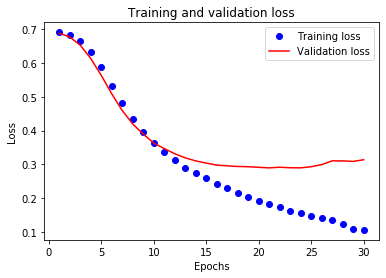

In [15]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

训练集和验证集上准确率变化：

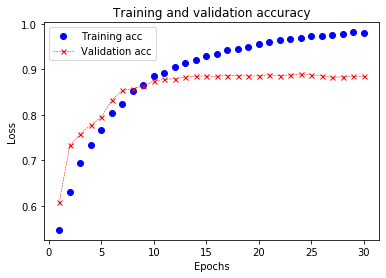

In [14]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, color='red', marker='x', linestyle='dashed',
        linewidth=0.5, markersize=5,label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

训练损失逐渐降低，训练准确度逐渐提高，这是我们所期望看到的。但验证损失和验证集上的准确率却在第10次迭代开始变差，模型在训练集上表现良好，在没有见过的数据上表现很差(泛化能力差)，模型发生了过拟合。可以使模型在第10次epoch时结束，来避免过拟合。

In [16]:
model_new = keras.Sequential()
model_new.add(keras.layers.Embedding(vocab_size, 50))
model_new.add(keras.layers.GlobalAveragePooling1D())
model_new.add(keras.layers.Dense(16, activation=tf.nn.relu))
model_new.add(keras.layers.Dropout(0.5))
model_new.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model_new.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model_new.fit(partial_x_train,partial_y_train,epochs=10,batch_size=512)
results = model_new.evaluate(test_data, test_labels, verbose=0)
print(results)

Train on 15000 samples
Epoch 1/10
15000/15000 [==============================] - 2s 132us/sample - loss: 0.6915 - accuracy: 0.5533
Epoch 2/10
15000/15000 [==============================] - 1s 91us/sample - loss: 0.6828 - accuracy: 0.6436
Epoch 3/10
15000/15000 [==============================] - 1s 89us/sample - loss: 0.6625 - accuracy: 0.7068
Epoch 4/10
15000/15000 [==============================] - 1s 97us/sample - loss: 0.6247 - accuracy: 0.7467
Epoch 5/10
15000/15000 [==============================] - 1s 85us/sample - loss: 0.5729 - accuracy: 0.7809
Epoch 6/10
15000/15000 [==============================] - 1s 90us/sample - loss: 0.5139 - accuracy: 0.8100
Epoch 7/10
15000/15000 [==============================] - 1s 95us/sample - loss: 0.4626 - accuracy: 0.8367
Epoch 8/10
15000/15000 [==============================] - 1s 94us/sample - loss: 0.4133 - accuracy: 0.8596
Epoch 9/10
15000/15000 [==============================] - 1s 81us/sample - loss: 0.3739 - accuracy: 0.8711
Epoch 10/10
1

用训练好的模型在新数据上做预测

In [17]:
model.predict(test_data)

array([[0.07404366],
       [0.9999701 ],
       [0.84090924],
       ...,
       [0.06889534],
       [0.22371787],
       [0.9506227 ]], dtype=float32)

In [18]:
sentence = 'This movie is so bad'
review = [word_index[w] for w in sentence.lower().split()]
review = keras.preprocessing.sequence.pad_sequences([review],
                                           value=word_index["<PAD>"],
                                           padding='post',
                                           maxlen=256)
print(review)
model.predict(review)

[[14 20  9 38 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


array([[0.380517]], dtype=float32)

给深度模型加入LSTM

In [19]:
new = keras.Sequential()
new.add(keras.layers.Embedding(vocab_size, 50))
new.add(keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
new.add(keras.layers.Dense(16, activation=tf.nn.relu))
new.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
new.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

new.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512)
results = new.evaluate(test_data, test_labels, verbose=0)
print(results)

Train on 15000 samples
Epoch 1/20
15000/15000 [==============================] - 42s 3ms/sample - loss: 0.6929 - accuracy: 0.5181
Epoch 2/20
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.6877 - accuracy: 0.5629
Epoch 3/20
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.6437 - accuracy: 0.6408
Epoch 4/20
15000/15000 [==============================] - 42s 3ms/sample - loss: 0.6277 - accuracy: 0.6317
Epoch 5/20
15000/15000 [==============================] - 42s 3ms/sample - loss: 0.5870 - accuracy: 0.7056
Epoch 6/20
15000/15000 [==============================] - 42s 3ms/sample - loss: 0.5645 - accuracy: 0.7367
Epoch 7/20
15000/15000 [==============================] - 37s 2ms/sample - loss: 0.5493 - accuracy: 0.7535
Epoch 8/20
15000/15000 [==============================] - 37s 2ms/sample - loss: 0.5302 - accuracy: 0.7623
Epoch 9/20
15000/15000 [==============================] - 39s 3ms/sample - loss: 0.5063 - accuracy: 0.7795
Epoch 10/20
15